In [1]:
import os
import datetime
import io
from urllib.request import urlopen, Request
import sqlite3
import pickle

import metpy.calc
from metpy.units import units 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import pandas as pd 

from synoptic.plots import map_metadata
import synoptic.services as ss
%matplotlib inline

data_root = "./local_data"
if not os.path.exists(data_root):
    os.makedirs(data_root)
obs_fpath = os.path.join(".", data_root, "basin_obs.h5")
metadata_fpath = os.path.join(".", data_root, "basin_ob_metadata.h5")

force_do = False

/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
def image_spoof(self, tile):
    """Thanks to Joshua Hrisko 
    https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
    """    
    # get the url of the street map API
    url = self._image_url(tile) 
    req = Request(url) 
    req.add_header('User-agent','Anaconda 3') 
    fh = urlopen(req)
    im_data = io.BytesIO(fh.read()) 
    fh.close() 
    # open image with PIL, set format, reformat for Cartopy
    img = Image.open(im_data) 
    img = img.convert(self.desired_tile_form)
    return (img, self.tileextent(tile), 'lower') 

def get_density(P,T,Td):
    """
    P in Pa
    T in K
    Td in K 
    """
    R_d = 287.05  # J/(kg·K)
    R_v = 461.495  # J/(kg·K)
    
    # Celsius for this
    Td_C = Td - 273.15
    
    # Calculate partial pressure of water vapour
    P_v = 6.11 * 10 ** (7.5 * Td_C / (237.3 + Td_C))
    
    # Calculate partial pressure of dry air
    P_d = P - P_v
    
    # Calculate air density
    rho = (P_d / (R_d * T)) + (P_v / (R_v * T))
    return rho

def reduce_pressure_to_mslp(P, T, h, L=0.0065):
    """
    Reduce pressure to mean sea level using the hypsometric equation.
    
    Parameters:
    P : float
        Observed pressure at altitude in hPa
    T : float
        Observed temperature at altitude in Celsius
    h : float
        Altitude in meters
    L : float, optional
        Temperature lapse rate in K/m, default is 0.0065 K/m
    
    Returns:
    float
        Pressure at sea level in hPa
    """
    if (np.nan in P) or (np.nan in T) or (np.nan in h):
        return np.nan
    ### TODO: lapse rate, humidity in air...
    R = 287  # Gas constant for dry air in J/(kg·K)
    g = 9.81  # Acceleration due to gravity in m/s^2
    T_kelvin = T + 273.15  # Convert temperature to Kelvin
    
    P0 = P * (1 + (L * h) / T_kelvin)**(g / (L * R))
    
    return P0

def plot_hline_lv(ax,lv_dict,c="red",lw=0.5):
    for k,v in lv_dict.items():
        # Option to label the line with k
        ax.axhline(v, color=c, lw=lw)
    return ax 

def save_pickle(data,fpath):
    with open(fpath, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(fpath):
    with open(fpath, 'rb') as f:
        return pickle.load(f)


In [3]:
# Terrain and roads etc
radius = "UCL21,50"
recent = 3*60*60
cimgt.Stamen.get_image = image_spoof  # reformat web request for street map spoofing
osm_img = cimgt.Stamen('terrain')  # spoofed, downloaded street map

df_meta = ss.stations_metadata(radius=radius, recent=recent)
df_meta

Checking for data recent=10800 minutes.

 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?radius=UCL21,50&recent=10800&token=🙈HIDDEN


,KVEL,RSVL,CUPH,RNGC2,CWHU1,LKFU1,MMTU1,TCKU1,SURC2,DRAC2,...,UTASH,UTWPO,UTWIS,UTBAS,UTMOP,JESU1,PC101,4276P,PC266,PC353
DISTANCE,19.83,22.1,40.78,47.71,44.78,49.48,31.68,38.54,44.82,45.17,...,16.85,33.18,47.71,38.92,45.65,27.72,23.86,26.05,24.98,16.51
ELEVATION,5262.0,5151.0,5725.0,5290.0,10498.0,10127.0,9552.0,9448.0,5960.0,6290.0,...,5710.0,7258.0,7927.0,8368.0,8076.0,4776.0,5855.0,4803.0,8426.0,5947.0
ELEV_DEM,5269.0,5200.1,5590.6,5295.3,10524.9,10157.5,9583.3,9471.8,6282.8,6282.8,...,5705.4,7263.8,7923.2,8366.1,8084.0,4780.2,NaN,NaN,8441.6,NaN
ID,61,878,902,964,1458,1482,1494,1509,1969,1971,...,151673,151977,151978,151979,151983,170574,172295,173578,175633,217351
MNET_ID,1,1005,19,106,25,25,25,25,2,2,...,4,4,4,4,4,23,247,208,247,247
NAME,Vernal Airport,ROOSEVELT-UNION HS,STARVATION DAM,RANGLEY 1E (POWER PLANT),CHEPETA,LAKEFORK #1,MOSBY MTN.,TROUT CREEK,DINOSAUR NM SUCCESS,DRAGON ROAD,...,US-40 at MP 140 Asphalt Ridge,US-191 at MP 369 Windy Point,US-191 at MP 386 Willie Spring,US-191 at MP 377 Bassett Spring,SR-44 at MP 9 Moose Pond,GREEN RIVER NEAR JENSEN 6ENE,Dry Fork Canyon,Dino Ozone Station,Little Mountain,Vernal West
RECORD_END,2023-11-28 18:39:00+00:00,2002-02-13 21:00:00+00:00,NaT,2023-10-21 03:00:00+00:00,2023-11-28 17:00:00+00:00,2023-11-28 17:00:00+00:00,2023-11-28 17:00:00+00:00,2023-11-28 17:00:00+00:00,2023-11-28 18:22:00+00:00,2023-11-28 18:18:00+00:00,...,2023-11-28 18:30:00+00:00,2023-11-28 18:20:00+00:00,2023-11-28 18:30:00+00:00,2023-11-28 18:30:00+00:00,2023-11-28 18:30:00+00:00,2023-11-28 18:30:00+00:00,2023-11-28 18:40:00+00:00,2022-05-27 03:10:00+00:00,2023-11-28 18:40:00+00:00,2023-11-28 18:40:00+00:00
RECORD_START,1997-01-01 00:00:00+00:00,1999-01-12 00:00:00+00:00,NaT,1997-01-01 00:00:00+00:00,2000-01-20 00:00:00+00:00,2000-01-20 00:00:00+00:00,2000-01-20 00:00:00+00:00,2000-01-20 00:00:00+00:00,1998-07-30 00:00:00+00:00,1998-07-29 00:00:00+00:00,...,2020-06-03 17:00:00+00:00,2020-06-04 17:10:00+00:00,2020-06-04 17:10:00+00:00,2020-06-04 17:10:00+00:00,2020-06-05 00:40:00+00:00,2021-10-29 15:41:00+00:00,2022-03-11 08:14:00+00:00,2022-04-26 21:10:00+00:00,2022-06-30 20:15:00+00:00,2023-05-16 08:14:00+00:00
RESTRICTED,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
STATE,UT,UT,UT,CO,UT,UT,UT,UT,CO,CO,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT


In [4]:
vars=["wind_speed","wind_direction","air_temp","dew_point_temperature",
            "pressure","snow_depth","solar_radiation",
            "relative_humidity","wind_gust","altimeter","soil_temp",
            "sea_level_pressure","snow_accum", "road_temp",
            "cloud_layer_1_code", "cloud_layer_2_code",
            "cloud_layer_3_code", "cloud_low_symbol",
            "cloud_mid_symbol", "cloud_high_symbol",
            "sonic_wind_direction", "peak_wind_speed",
            "ceiling", "sonic_wind_speed", "soil_temp_ir",
            "snow_smoothed", "snow_accum_manual", "snow_water_equiv",
            "precipitable_water_vapor", "net_radiation_sw",
            "sonic_air_temp", "sonic_vertical_vel",
            "vertical_heat_flux", "outgoing_radiation_sw",
            "PM_25_concentration", "ozone_concentration",
            "derived_aerosol_boundary_layer_depth",
            "NOx_concentration", "PM_10_concentration",
            "visibility_code", "cloud_layer_1", "cloud_layer_2",
            "cloud_layer_3", "wet_bulb_temperature"
            ]

# Let's try KVEL time series and computed density of air 
# stid takes a tuple of station IDs and returns a list of dataframes
df = ss.stations_timeseries(stid="KVEL",start=datetime.datetime(2023,9,1,0,0,0),end=datetime.datetime(2023,9,25,0,0,0),
                                vars=vars)
rho = get_density(df["pressure"],df["air_temp"]+273.15,df["dew_point_temperature"]+273.15)
df = df.assign(air_density=rho.values)
df


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=KVEL&start=202309010000&end=202309250000&vars=wind_speed,wind_direction,air_temp,dew_point_temperature,pressure,snow_depth,solar_radiation,relative_humidity,wind_gust,altimeter,soil_temp,sea_level_pressure,snow_accum,road_temp,cloud_layer_1_code,cloud_layer_2_code,cloud_layer_3_code,cloud_low_symbol,cloud_mid_symbol,cloud_high_symbol,sonic_wind_direction,peak_wind_speed,ceiling,sonic_wind_speed,soil_temp_ir,snow_smoothed,snow_accum_manual,snow_water_equiv,precipitable_water_vapor,net_radiation_sw,sonic_air_temp,sonic_vertical_vel,vertical_heat_flux,outgoing_radiation_sw,PM_25_concentration,ozone_concentration,derived_aerosol_boundary_layer_depth,NOx_concentration,PM_10_concentration,visibility_code,cloud_layer_1,cloud_layer_2,cloud_layer_3,wet_bulb_temperature&token=🙈HIDDEN


,air_temp,altimeter,ceiling,cloud_layer_1_code,cloud_layer_1,cloud_layer_2_code,cloud_layer_2,cloud_layer_3_code,cloud_layer_3,dew_point_temperature_set_1,...,pressure,relative_humidity,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_gust,wind_speed,wind_u,wind_v,air_density
date_time,,,,,,,,,,,,,,,,,,,,,
2023-09-01 00:00:00+00:00,33.0,101354.563,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,83499.00,10.52,NaN,99564.56,280.0,NaN,3.601,3.546,-0.625,0.950121
2023-09-01 00:05:00+00:00,33.0,101354.563,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,83499.00,10.52,NaN,99564.56,260.0,NaN,2.572,2.533,0.447,0.950121
2023-09-01 00:10:00+00:00,33.0,101354.563,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,83499.00,12.18,NaN,99564.47,260.0,NaN,2.572,2.533,0.447,0.950117
2023-09-01 00:15:00+00:00,33.0,101354.563,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,83499.00,11.32,NaN,99564.52,270.0,NaN,3.087,3.087,0.000,0.950119
2023-09-01 00:20:00+00:00,33.0,101354.563,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,83499.00,11.32,NaN,99564.52,270.0,NaN,2.572,2.572,0.000,0.950119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24 23:45:00+00:00,23.0,102235.024,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,84224.35,16.22,NaN,101017.69,80.0,NaN,1.543,-1.520,-0.268,0.990740
2023-09-24 23:50:00+00:00,23.0,102235.024,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,84224.35,16.22,NaN,101017.69,60.0,NaN,2.058,-1.782,-1.029,0.990740
2023-09-24 23:53:00+00:00,22.8,102235.024,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,-4.4,...,84224.35,15.93,101860.0,101029.90,70.0,NaN,1.543,-1.450,-0.528,0.991410


In [22]:
stids = list(df_meta.columns.unique())
# df.attrs

In [6]:
if force_do or os.path.exists(metadata_fpath) is False:
    STID_META = dict()
    for stid in stids:
        df_meta = ss.stations_metadata(stid=stid)
        STID_META[stid] = df_meta
    save_pickle(STID_META,metadata_fpath)  
else:
    STID_META = load_pickle(metadata_fpath)


In [7]:
# For each station in stids, let's fetch the dataframe. We will have a list of them ready to concatenate or feed into the SQL database
if force_do or os.path.exists(obs_fpath) is False:
    df_list = []
    for stid in stids:
        print(stid)
        try:
            _df = ss.stations_timeseries(stid=stid,start=datetime.datetime(2022,11,17,0,0,0),end=datetime.datetime(2023,11,17,0,0,0),
                                    vars=vars,
                                        verbose=False)
        except AssertionError:
            print("Skipping",stid)
            continue

        stid_lat = STID_META[stid].loc["latitude"].values.squeeze()
        stid_lon = STID_META[stid].loc["longitude"].values.squeeze()
        elev = STID_META[stid].loc["ELEVATION"].values.squeeze()*0.304
            
        if ("pressure" in _df.columns) and ("air_temp" in _df.columns) and ("dew_point_temperature" in _df.columns):
            rho = get_density(_df["pressure"],_df["air_temp"]+273.15,_df["dew_point_temperature"]+273.15)
            _df = _df.assign(air_density=rho.values)
        _df = _df.assign(stid=stid, elevation=elev, latitude=stid_lat,longitude=stid_lon)
        
        # df.loc[df[stid] == stid, 'latitude'] = stid_lat
        # df.loc[df[stid] == stid, 'longitude'] = stid_lon
        # df.loc[df[stid] == stid, 'elevation'] = elev
        
        # df["latitude"] = stid_lat 
        # df["longitude"] = stid_lon
        # df["elev"] = elev
        
        # Drop everything that isn't in...
        # good_cols = vars + ["date_time","wind_u","wind_v","air_density","stid","elevation","latitude","longitude"]
        # df.drop(columns=[col for col in df if col not in good_cols], inplace=True)
        
        # pd.to_datetime(df['date_time']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')
        pd.to_datetime(_df.index.strftime('%Y-%m-%dT%H:%M:%SZ'))
        df_list.append(_df)
    # conn.commit()
        # break
    df = pd.concat(df_list, axis=0, ignore_index=False)
    print("Original file size:",np.sum(df.memory_usage())/1E6,"MB")
    # Find columns using float64
    col64 = [df.columns[i] for i in range(len(list(df.columns))) if (df.dtypes.iloc[i] == np.float64)]
    change_dict = {c:np.float32 for c in col64}
    df = df.astype(change_dict)
    print("New (float32) file size:",np.sum(df.memory_usage())/1E6,"MB")
    df.to_hdf(obs_fpath, key='df', mode='w')  
else:
    df = pd.read_hdf(obs_fpath)
    print("Dataframe file size:",np.sum(df.memory_usage())/1E6,"MB")
df

Dataframe file size: 347.380008 MB


,air_temp,altimeter,ceiling,cloud_layer_1_code,cloud_layer_1,cloud_layer_2_code,cloud_layer_2,cloud_layer_3_code,cloud_layer_3,dew_point_temperature_set_1,...,soil_temp,soil_temp_set_2,dew_point_temperature_set_1d,road_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5,NOx_concentration,ozone_concentration,PM_25_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2022-11-18 22:45:00+00:00,0.000,102404.343750,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18 22:50:00+00:00,-1.000,102404.343750,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18 22:53:00+00:00,-0.600,102404.343750,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,-13.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18 22:55:00+00:00,-1.000,102404.343750,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18 23:00:00+00:00,-1.000,102438.203125,NaN,1.0,"{'sky_condition': 'clear', 'height_agl': None}",NaN,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16 23:20:00+00:00,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-16 23:30:00+00:00,9.983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-16 23:40:00+00:00,9.944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


About to plot


Text(0.0, 1.0, 'Station Locations')

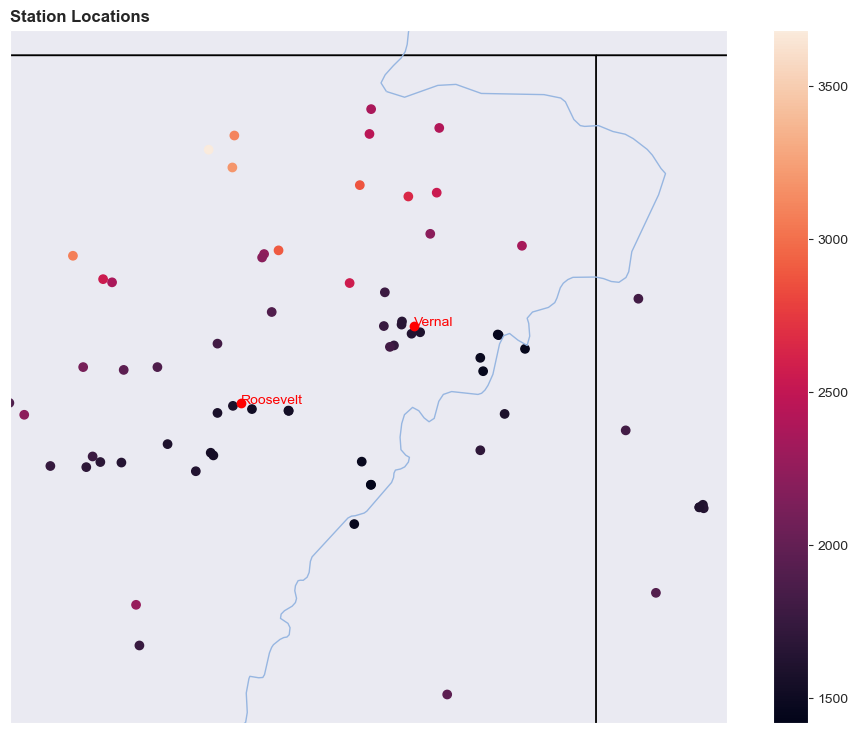

In [8]:
fig = plt.figure(figsize=(12, 9))  # open matplotlib figure
ax = plt.axes(projection=osm_img.crs)  # project using coordinate reference system (CRS) of street map
# fig,ax = plt.subplots(1,subplot_kw=dict(projection=osm_img.crs))

# Reset stids from this new dataframe 
stids = list(df["stid"].unique())
lats = []
lons = []
elevs = []
for stid in stids:
    elevs.append(STID_META[stid].loc["ELEVATION"].values.squeeze()*0.304)
    lats.append(STID_META[stid].loc["latitude"].values.squeeze())
    lons.append(STID_META[stid].loc["longitude"].values.squeeze())    

# lats = df.loc["latitude"]
# lons = df.loc["longitude"]
# stids = df.loc["stid"]


sc = ax.scatter(lons, lats, c=elevs, transform=ccrs.PlateCarree())#, **scatter_kwargs)
# for lon, lat, stid, elev in zip(lons, lats, stids, elevs):
    # Colour-code by altitude?
    # sc = ax.scatter(lon,lat,stid,transform=ccrs.PlateCarree(),c=elev)
    # ax.text(lon, lat, stn, transform=ccrs.PlateCarree(),)# **text_kwargs)
    # pass
    
cbar = fig.colorbar(sc)

# Add reference towns in RED
towns = {
    "Vernal":[40.4555,-109.5287],
    "Roosevelt":[40.2994,-109.9888],
}
for town,latlon in towns.items():
    ax.scatter(latlon[1], latlon[0], color='red',transform=ccrs.PlateCarree())#, **scatter_kwargs)
    ax.text(latlon[1],latlon[0],town,color='red',transform=ccrs.PlateCarree())


ax.add_feature(cfeature.STATES.with_scale("10m"))
ax.add_feature(cfeature.RIVERS.with_scale("10m"))
# ax.stock_img()
# ax.add_feature(cfeature.NaturalEarthFeature("physical","",scale="10m"))

extent = [-110.6,-108.7,39.65,41.05]
ax.set_extent(extent)  # set extents

print("About to plot")


# empirical solve for scale based on zoom
# scale = np.ceil(-np.sqrt(2) * np.log(np.divide((extent[1] - extent[0]) / 2.0, 350.0)))
# scale = (scale < 20) and scale or 19  # scale cannot be larger than 19
# ax.add_image(osm_img, int(scale))  # add OSM with zoom specification

ax.set_title("Station Locations", loc="left", fontweight="bold")
# fig.tight_layout()
# fig.show()

In [9]:
STID_META.keys()
STID_META["KVEL"]

,KVEL
ELEVATION,5262.0
ELEV_DEM,5269.0
ID,61
MNET_ID,1
NAME,Vernal Airport
RECORD_END,2023-11-18 20:20:00+00:00
RECORD_START,1997-01-01 00:00:00+00:00
RESTRICTED,False
STATE,UT
STATUS,ACTIVE


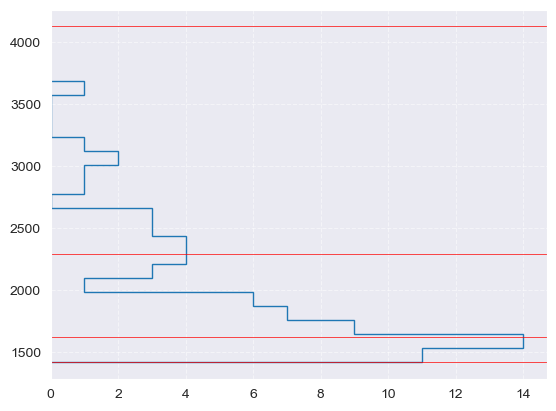

In [10]:
# Explore winter (DJFM 2022-2023)
# Find unique stations with snow depth available in the dataset
level_dict = {"Ouray":1425,"Vernal":1622,"Split Mtn":2294,"Kings Pk":4123}
counts, bins = np.histogram(elevs,bins=20)
fig,ax = plt.subplots(1)
ax.stairs(counts, bins,orientation="horizontal")
ax = plot_hline_lv(ax,level_dict,c="red",lw=0.5)


In [11]:
def get_closest_non_nan(df, column, target_time, tolerance):
    # Find the closest index to the target time within the tolerance
    
    # If whole column is nan, just return None
    # print(df[column])
    is_all_nan = df[column].isna().all()
    # print(is_all_nan)
    if is_all_nan:
        return np.nan
    
    closest_time = df.index.get_indexer([target_time], method='nearest')[0]
    time_diff = abs(df.index[closest_time] - target_time)

    # Check if within tolerance and non-NaN
    if time_diff <= pd.Timedelta(tolerance) and not pd.isna(df.at[df.index[closest_time], column]):
        return df.at[df.index[closest_time], column]

    # Search backwards and forwards for the closest non-NaN value within tolerance
    for i in range(1, tolerance.total_seconds() // df.index.freq.delta.total_seconds() + 1):
        for time_shift in [-i, i]:
            new_time = df.index[closest_time] + pd.Timedelta(seconds=time_shift * df.index.freq.delta.total_seconds())
            if new_time in df.index:
                if abs(new_time - target_time) <= pd.Timedelta(tolerance) and not pd.isna(df.at[new_time, column]):
                    return df.at[new_time, column]
    
    return np.nan  # Return None if no value found within tolerance


In [12]:
def get_profile_df(dt,df,elevs,stids,temp_type="theta"):
    profile_data = []
    for elev,stid in zip(elevs,stids):
        print(stid)
        # Time window is just for memory convenience - tolerance is set later
        sub_df = df[
                    (df['stid'] == stid) &
                    (df.index <= dt + pd.Timedelta(minutes=60)) &
                    (df.index >= dt - pd.Timedelta(minutes=60))
                    ]
        
        # print(sub_df["air_temp"])
        
        # i = sub_df.index.get_indexer([prof_dt,],method='nearest')
        # print(i)
        if len(sub_df) == 0:
            print("no measurement in this range.") 
            continue
            
            
        # temp = sub_df["air_temp"].iloc[i]
        temp = get_closest_non_nan(sub_df, "air_temp", dt, pd.Timedelta('30 minutes'))
        print(temp)
        
        elev = get_closest_non_nan(sub_df, "elevation", dt, pd.Timedelta('30 minutes'))
        print(elev)
        
        if temp_type == "drybulb":
            if (not np.isnan(temp)) and (not np.isnan(elev)):
                profile_data.append([elev,temp])
                
        elif temp_type == "theta":
            # p = sub_df["pressure"].iloc[i]
            p = get_closest_non_nan(sub_df, "pressure", dt, pd.Timedelta('30 minutes'))
            
            # Can we estimate p from elev?
            
            if (not np.isnan(temp)) and (not np.isnan(p)):
                
                theta = metpy.calc.potential_temperature(p*units("pascal"),temp*units("celsius")).magnitude
                # print(theta)
                
    
                # print(elev)
                
                profile_data.append([elev,theta])
                print("Added theta", theta, "at", elev,)
            print("Skipping due to missing in something:", temp, p)
    theta_df = pd.DataFrame(profile_data,columns=["elevation",temp_type])
    return theta_df

dt = pd.Timestamp(datetime.datetime(2023,2,6,23,0,0), tz="UTC")
theta_df = get_profile_df(dt,df,elevs,stids,temp_type="drybulb")
theta_df

KVEL
-4.0
1599.648
RNGC2
no measurement in this range.
CWHU1
-9.6
3191.392
LKFU1
-6.4
3078.608
MMTU1
-5.9
2903.808
TCKU1
-5.5
2872.192
SURC2
0.0
1811.84
DRAC2
1.667
1912.16
CHPU1
no measurement in this range.
DIAU1
-5.0
2349.92
FIVU1
-0.556
2273.92
MCKU1
0.0
2043.488
USWU1
1.667
1966.576
WHBU1
2.778
2508.0
WNTU1
-1.667
2242.912
SFLU1
-2.778
1592.96
YLSU1
2.222
2371.2
KGCU1
-4.3
2653.008
NUTU1
3.889
1760.16
WHRU1
1.389
2237.744
TR383
no measurement in this range.
BLAU1
0.556
2222.544
UINU1
0.0
1498.112
K74V
-2.0
1571.984
KU69
no measurement in this range.
UTSTV
-5.611
1738.88
DNOC2
-2.939
1824.0
K4V0
-1.7
1604.512
MHMU1
-4.111
2105.504
A1388
-5.9
1602.688
A1633
-6.5
1696.624
A1622
-7.2
1463.152
A1386
-4.2
1889.968
SPMU1
-4.222
1472.272
LRFU1
-6.278
1639.776
LFKU1
-1.7
2558.768
SPKU1
-8.7
3103.232
QRS
-0.433
1583.84
QV4
1.433
1661.664
TADU1
2.161
1887.232
WTRU1
30.889
2199.136
UTVU1
-7.089
1418.16
E3712
-2.778
1755.296
A3822
nan
1459.2
A3823
-1.8
1647.68
UCC33
-1.944
1661.056
UCC34
-3.77

,elevation,drybulb
0,1599.647949,-4.000
1,3191.392090,-9.600
2,3078.607910,-6.400
3,2903.808105,-5.900
4,2872.191895,-5.500
5,1811.839966,0.000
6,1912.160034,1.667
7,2349.919922,-5.000
8,2273.919922,-0.556
9,2043.488037,0.000


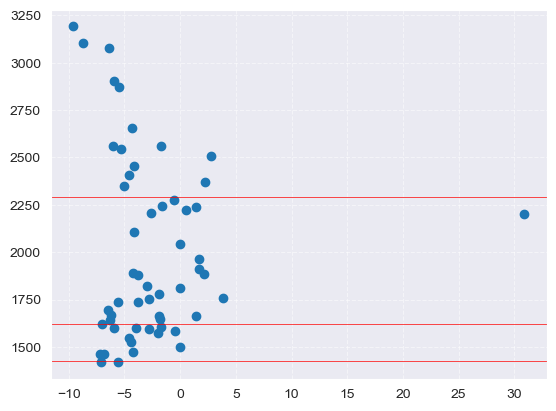

In [13]:
fig,ax = plt.subplots(1)
ax.scatter(theta_df["drybulb"],theta_df["elevation"])

level_dict = {"Ouray":1425,"Vernal":1622,"Split Mtn":2294}
ax = plot_hline_lv(ax,level_dict,c="red",lw=0.5)


KVEL
-4.0
1599.648
Added theta 282.86938018244973 at 1599.648
Skipping due to missing in something: -4.0 84029.07
RNGC2
no measurement in this range.
CWHU1
-9.6
3191.392
Skipping due to missing in something: -9.6 nan
LKFU1
-6.4
3078.608
Skipping due to missing in something: -6.4 nan
MMTU1
-5.9
2903.808
Skipping due to missing in something: -5.9 nan
TCKU1
-5.5
2872.192
Skipping due to missing in something: -5.5 nan
SURC2
0.0
1811.84
Skipping due to missing in something: 0.0 nan
DRAC2
1.667
1912.16
Skipping due to missing in something: 1.667 nan
CHPU1
no measurement in this range.
DIAU1
-5.0
2349.92
Skipping due to missing in something: -5.0 nan
FIVU1
-0.556
2273.92
Skipping due to missing in something: -0.556 nan
MCKU1
0.0
2043.488
Skipping due to missing in something: 0.0 nan
USWU1
1.667
1966.576
Skipping due to missing in something: 1.667 nan
WHBU1
2.778
2508.0
Skipping due to missing in something: 2.778 nan
WNTU1
-1.667
2242.912
Skipping due to missing in something: -1.667 nan
SFLU1


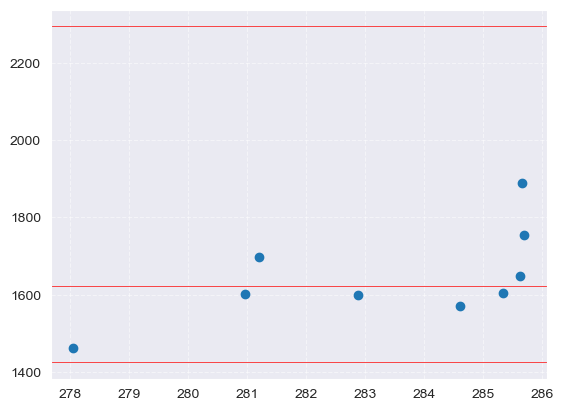

In [14]:
theta_df = get_profile_df(dt,df,elevs,stids,temp_type="theta")
fig,ax = plt.subplots(1)
ax.scatter(theta_df["theta"],theta_df["elevation"])

level_dict = {"Ouray":1425,"Vernal":1622,"Split Mtn":2294}
ax = plot_hline_lv(ax,level_dict,c="red",lw=0.5)

In [15]:
# What stations measure ozone?
ozone_stid = list(df["stid"][~np.isnan(df["ozone_concentration"])].unique())

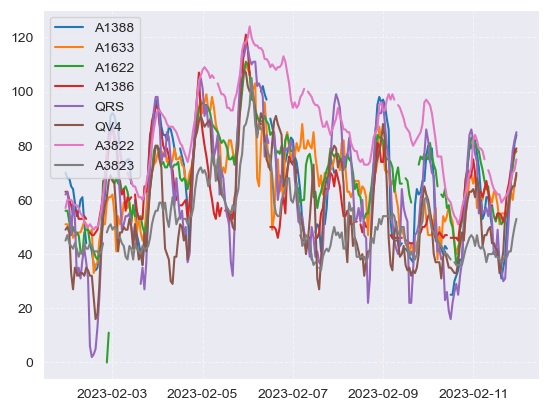

In [16]:
fig,ax = plt.subplots(1)
for stid in ozone_stid:
    sub_df = df[(df["stid"] == stid) & 
                (df.index <= dt + pd.Timedelta(days=5)) &
                (df.index >= dt - pd.Timedelta(days=5))
                    ]
    ax.plot(sub_df["ozone_concentration"],label=stid)
ax.legend()

In [17]:
# What stations measure snow depth?
snod_stid = list(df["stid"][~np.isnan(df["snow_depth"])].unique())
# What is the lowest station with snow depth?
columns = ["stid","elevation",]
data = []
for stid in snod_stid:
    data.append([stid,int(STID_META[stid].loc["ELEVATION"].values[0])])
df_stn_snow = pd.DataFrame(data,columns=columns)
df_stn_snow.sort_values(by="elevation")

,stid,elevation
15,COOPOURU1,4674
12,COOPJENU1,4755
9,COOPDINU1,4802
16,COOPROSU1,5014
11,COOPFTDU1,5052
13,COOPMYTU1,5085
18,UTMYT,5087
7,COOPRNGC2,5277
17,COOPVELU1,5345
10,COOPDSNU1,5551


In [18]:
STID_META["COOPJENU1"]

,COOPJENU1
ELEVATION,4755.0
ELEV_DEM,4734.3
ID,58752
MNET_ID,77
NAME,JENSEN
RECORD_END,2023-11-18 01:00:00+00:00
RECORD_START,2016-06-08 02:28:00+00:00
RESTRICTED,False
STATE,UT
STATUS,ACTIVE


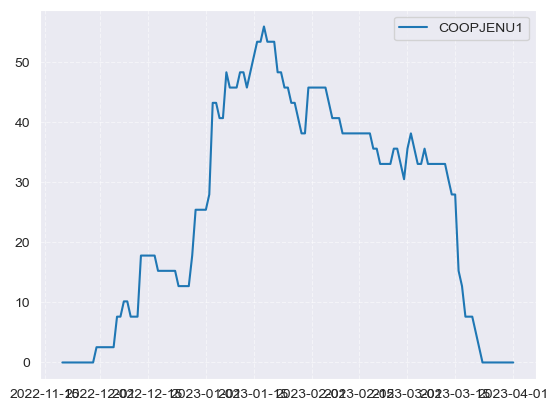

In [19]:
dt0 = pd.Timestamp(datetime.datetime(2022,11,20,0,0,0), tz="UTC")
dt1 = pd.Timestamp(datetime.datetime(2023,4,1,0,0,0), tz="UTC")

fig,ax = plt.subplots(1)
sub_df = df[(df["stid"] == "COOPJENU1") & 
            (df.index <= dt1) &
            (df.index >= dt0)] #
            # (df["snow_depth"] < 1340)
            #     ]
# cm 
ax.plot(sub_df["snow_depth"]/10,label="COOPJENU1") 
ax.legend()
# sub_df["snow_depth"].min()

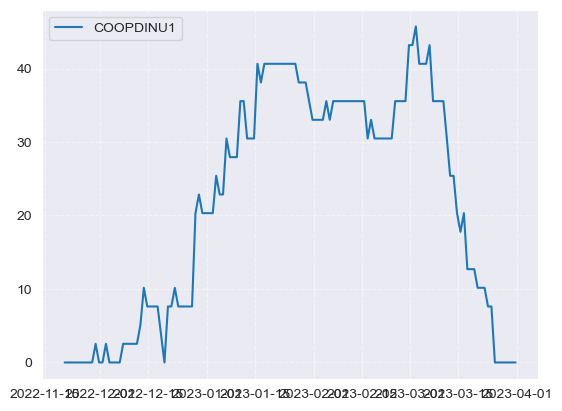

In [20]:
# BAD:
# COOPOURU1
# 
fig,ax = plt.subplots(1)
sub_df = df[(df["stid"] == "COOPDINU1") & 
            (df.index <= dt1) &
            (df.index >= dt0)] #
            # (df["snow_depth"] < 1340)
            #     ]
# cm 
ax.plot(sub_df["snow_depth"]/10,label="COOPDINU1") 
ax.legend()

In [21]:
# DATA EXPLORATION
# First, a look at the distribution of various things







import seaborn as sns
from matplotlib import rcParams

# Set Helvetica as the font
rcParams['font.family'] = 'Helvetica'

# Sample dataframe (replace this with your actual dataframe)
# df = pd.read_csv("your_data.csv")
df['date_time'] = pd.to_datetime(df['date_time'])

df_x = df.copy(deep=True)

# Calculate wind speed
wind_speed = np.sqrt(df['wind_u']**2 + df['wind_v']**2)
wind_direction = np.degrees(np.arctan2(df['wind_v'], df['wind_u']))

# Adjust wind direction to meteorological coordinates (0-360 degrees, measured clockwise from true north)
wind_direction = (wind_direction + 360) % 360
 
# We need to re-do the obs table - first let's just convert elevation
mslp = reduce_pressure_to_mslp(df_x["pressure"]/100, df_x["air_temp"], df_x["elevation"])


# deep copy dataframe 
# df_x
# assign these new columns 
df_x = df_x.assign(wind_speed=wind_speed, wind_direction=wind_direction, mslp=mslp)


KeyError: 'date_time'

In [ ]:
import math

def plot_distributions(df, columns_to_plot, title):
    num_plots = len(columns_to_plot)
    num_rows = math.ceil(num_plots / 2)  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))
    fig.suptitle(title)
    
    # Flatten the 2D array of axes if there's more than one row
    axes = axes.flatten() if num_rows > 1 else axes
    # vars=["wind_speed","wind_direction","air_temp","dew_point_temperature","pressure","snow_depth","solar_radiation","ozone_concentration"]

    x_lims = {
                "wind_direction":[1,360],
                "wind_speed":[0,30],
                "air_temp":[-40,40],
                "dew_point_temperature":[-40,20],
                "mslp":[950,1050],
                "pressure":[75000,87500],
                "elevation":[1000,5000],
                # "snow_depth":[0,1],
                "solar_radiation":[0,200],
                "ozone_concentration":[0,150]
    }
    
    for i, col in enumerate(columns_to_plot):
            
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        
        if col in x_lims.keys():
            axes[i].set_xlim(x_lims[col])
        
    # Remove any unused subplots
    for i in range(num_plots, num_rows * 2):
        fig.delaxes(axes[i])
        
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()


In [ ]:
columns_to_plot = ["wind_direction", "wind_speed", "air_temp", "dew_point_temperature", "mslp", "pressure", "elevation", "snow_depth",
                            "solar_radiation","ozone_concentration"]

# Plot for the entire dataframe
plot_distributions(df_x, columns_to_plot+["elevation",], 'Distribution of Variables for Entire Dataset')

In [ ]:
# Extract the month from the date_time column
df_x['month'] = df_x['date_time'].dt.month

# Split the dataframe based on months
df_winter_spring = df_x[df_x['month'].isin([12, 1, 2, 3])]
df_other_months = df_x[~df_x['month'].isin([12, 1, 2, 3])]

# Plot for the winter and spring months
plot_distributions(df_winter_spring, columns_to_plot, 'Distribution of Variables for Dec-Jan-Feb-Mar')


In [ ]:
unique_stid = df["stid"].unique()
print(unique_stid)

def plot_stid_locs(stids):
    
    fig = plt.figure(figsize=(12, 9))  # open matplotlib figure
    ax = plt.axes(projection=osm_img.crs)  # project using coordinate reference system (CRS) of street map
    
    _lats = []
    _lons = []
    for s in stids:
        lon = lons[s]
        lat = lats[s]
        elev = elevs[s]
    
        ax.text(lon, lat, s, transform=ccrs.PlateCarree(),)# **text_kwargs)
        _lats.append(lat)
        _lons.append(lon)
    sc = ax.scatter(lons,lats,transform=ccrs.PlateCarree(),c=elevs)
    cbar = fig.colorbar(sc)
    
    ax.add_feature(cfeature.STATES.with_scale("10m"))
    ax.add_feature(cfeature.RIVERS.with_scale("10m"))
    # ax.stock_img()
    # ax.add_feature(cfeature.NaturalEarthFeature("physical","",scale="10m"))
    
    extent = [-110.6,-108.7,39.65,41.05]
    ax.set_extent(extent)  # set extents
    
    # empirical solve for scale based on zoom
    scale = np.ceil(-np.sqrt(2) * np.log(np.divide((extent[1] - extent[0]) / 2.0, 350.0)))
    scale = (scale < 20) and scale or 19  # scale cannot be larger than 19
    ax.add_image(osm_img, int(scale))  # add OSM with zoom specification
    
    ax.set_title("Station Locations", loc="left", fontweight="bold")
    fig.tight_layout()
    # fig.show()
    
plot_stid_locs(unique_stid)

In [ ]:

# Plot for the other months
plot_distributions(df_other_months, columns_to_plot, 'Distribution of Variables for Remaining Months')

This is where there is potential for dimension reduction such as PCAs.